In [235]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [236]:
with open("game_data.json", "r") as file:
    json_data = json.load(file)

In [237]:
# create the game dataframe pulling some table level stats into the main frame
games_df = pd.DataFrame(json_data)
df_norm = pd.json_normalize(games_df['options'])
games_df = pd.concat([games_df, df_norm], axis=1)
games_df['Player Count'] = games_df['players'].apply(lambda x: len(x))
def calc_elo(players):
    elo = 0.0
    total_players = 0.0
    for player in players:
        total_players += 1
        elo += float(player['rank_after_game'])
    return elo / total_players

games_df['Average Elo'] = games_df['players'].apply(lambda x: calc_elo(x))
games_df['Min Elo'] = games_df['players'].apply(lambda x: min(float(y['rank_after_game']) for y in x))
games_df['Winning Seat'] = games_df['table_stats'].apply(lambda x: x['winning_position'])
games_df = games_df.reset_index().rename(columns={'index': 'game_index'})

In [238]:
# create the player dataframe
def mark_winner(group):
    for player in group:
        player['winner'] = False
    group[0]['winner'] = True
    return group

games_df['players'] = games_df['players'].apply(lambda x: mark_winner(x))
player_df = games_df.explode('players')
player_df = player_df.reset_index(drop=True)
player_norm = pd.json_normalize(player_df['players'])
player_df = pd.concat([player_df, player_norm], axis=1)
player_df['score'] = player_df['score'].astype('int64')

In [239]:
def print_winning_percentages(game_results, subtitle):
    winning_positions = game_results['table_stats'].apply(lambda x: int(x['winning_position']))
    winning_positions = winning_positions[winning_positions != 0]
    win_counts = winning_positions.value_counts()

    # Create the bar chart
    bars = plt.bar(win_counts.keys(), win_counts.values)
    plt.xlabel("Player Position")
    plt.ylabel("Number of Wins")
    plt.title(f"Wins by Player Position in {subtitle}")
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.show()

There are 8876 4-player games in the dataset out of 20439 total games


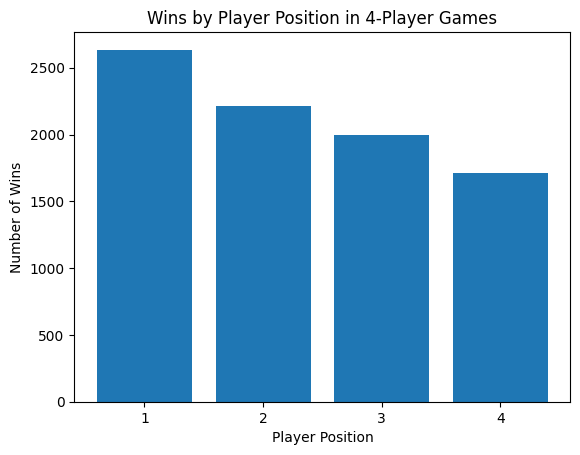

In [240]:
four_player_games = games_df[games_df['Player Count'] == 4]
print(f"There are {len(four_player_games)} 4-player games in the dataset out of {len(games_df)} total games")
print_winning_percentages(four_player_games, "4-Player Games")

There are 4406 3-player games in the dataset out of 20439 total games


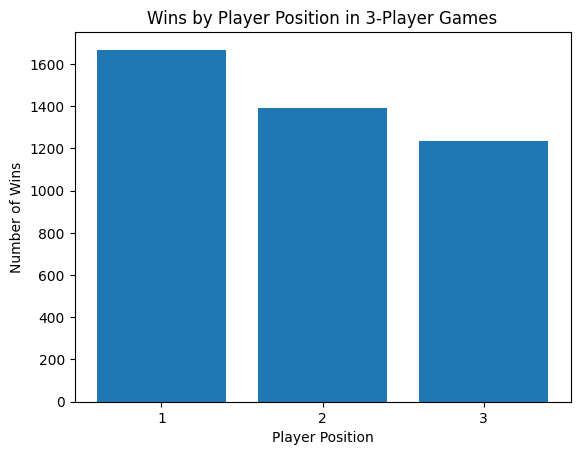

In [241]:
three_player_games = games_df[games_df['Player Count'] == 3]
print(f"There are {len(three_player_games)} 3-player games in the dataset out of {len(games_df)} total games")
print_winning_percentages(three_player_games, "3-Player Games")

There are 253 high ELO 4-player games in the dataset out of 20439 total games


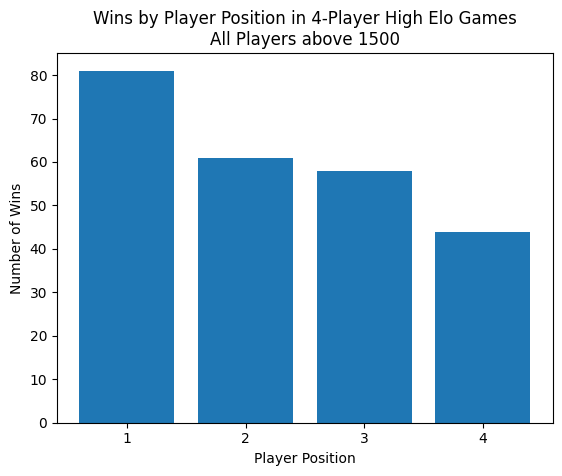

In [242]:
high_elo_four = four_player_games[four_player_games['Min Elo'] > 1500]
print(f"There are {len(high_elo_four)} high ELO 4-player games in the dataset out of {len(games_df)} total games")
print_winning_percentages(high_elo_four, "4-Player High Elo Games\nAll Players above 1500")

There are 3220 high ELO 4-player games in the dataset out of 20439 total games


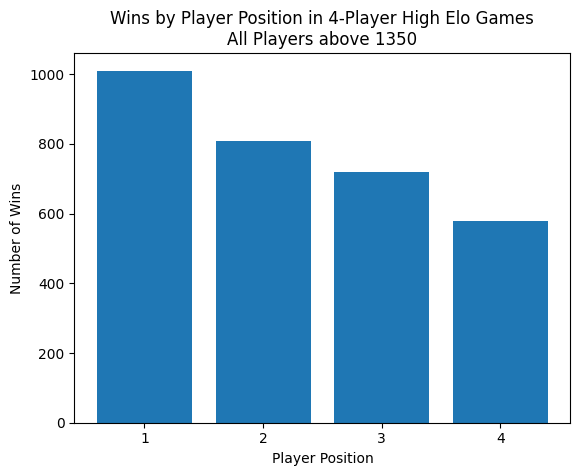

In [243]:
medium_elo_four = four_player_games[four_player_games['Min Elo'] > 1350]
print(f"There are {len(medium_elo_four)} high ELO 4-player games in the dataset out of {len(games_df)} total games")
print_winning_percentages(medium_elo_four, "4-Player High Elo Games\nAll Players above 1350")

<Axes: >

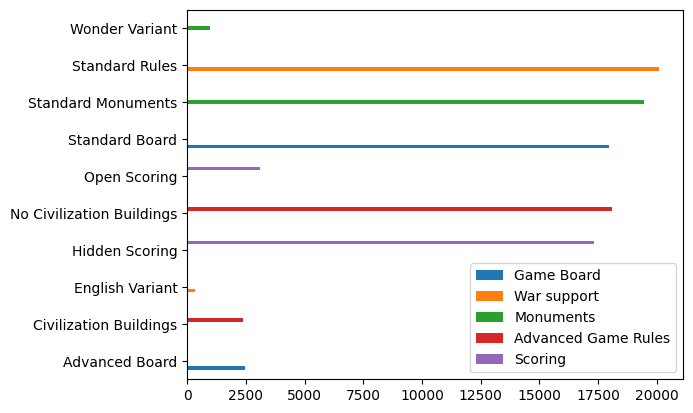

In [244]:
game_options = pd.json_normalize(games_df['options'])
game_options.drop(columns=["Game speed", "Time allotted to each player", "Playing hours", "Game mode"], inplace=True)
game_options.apply(pd.Series.value_counts).plot.barh(rot=0)

<Axes: title={'center': 'Game options in 4 player ELO >1500 tables'}>

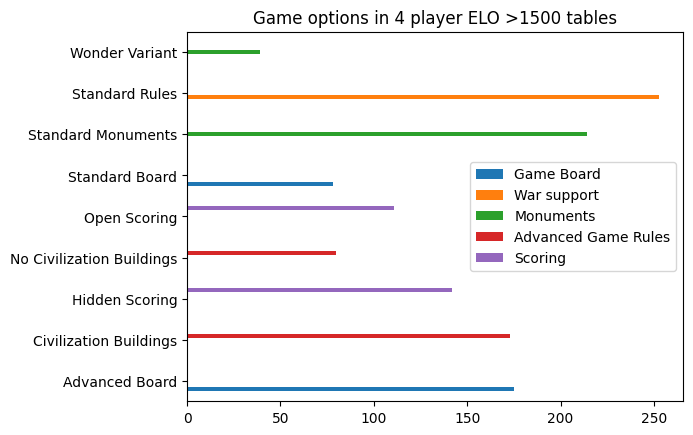

In [245]:
game_options = pd.json_normalize(high_elo_four['options'])
game_options.drop(columns=["Game speed", "Time allotted to each player", "Playing hours", "Game mode"], inplace=True)
game_options.apply(pd.Series.value_counts).plot.barh(rot=0, title="Game options in 4 player ELO >1500 tables")

In [246]:
ranks = pd.json_normalize(games_df['players'].explode('players'))['rank_after_game'].astype('float64')
rank_counts = ranks.value_counts().sort_index()

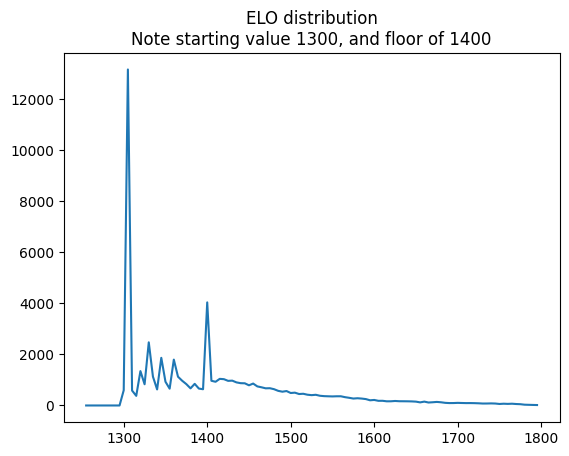

In [247]:
bin_edges = np.arange(1250, 1800, 5)
# Group the ELO ranks into bins of 10 points
elo_rank_bins = pd.cut(ranks, bins=bin_edges)
bin_counts = elo_rank_bins.value_counts().sort_index()
bin_midpoints = bin_edges[:-1] + 5
plt.plot(bin_midpoints, bin_counts.values)
plt.title("ELO distribution\nNote starting value 1300, and floor of 1400")
plt.show()

Text(0.5, 1.0, 'ELO Distribution after floor')

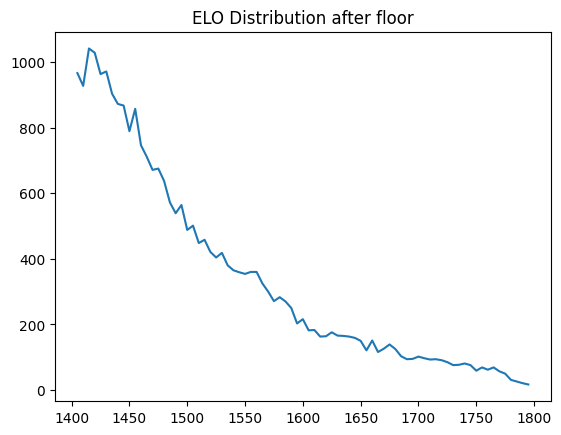

In [248]:
rank_counts = high_ranks.value_counts().sort_index()
bin_edges = np.arange(1400, 1800, 5)
# Group the ELO ranks into bins of 10 points
elo_rank_bins = pd.cut(high_ranks, bins=bin_edges)
bin_counts = elo_rank_bins.value_counts().sort_index()
bin_midpoints = bin_edges[:-1] + 5
plt.plot(bin_midpoints, bin_counts.values)
plt.title("ELO Distribution after floor")

In [249]:
player_df.columns

Index(['game_index', 'options', 'players', 'table_stats', 'Game mode',
       'Game speed', 'Time allotted to each player', 'Playing hours',
       'Game Board', 'War support', 'Monuments', 'Advanced Game Rules',
       'Scoring', 'Player Count', 'Average Elo', 'Min Elo', 'Winning Seat',
       'score', 'score_aux', 'gamerank', 'rank_after_game', 'winner',
       'stats.reflexion_time', 'stats.reflexion_time_sd', 'stats.red_points',
       'stats.black_points', 'stats.green_points', 'stats.blue_points',
       'stats.treasure_picked_up', 'stats.turns_number',
       'stats.revolts_won_attacker', 'stats.revolts_won_defender',
       'stats.revolts_lost_attacker', 'stats.revolts_lost_defender',
       'stats.wars_won_attacker', 'stats.wars_won_defender',
       'stats.wars_lost_attacker', 'stats.wars_lost_defender',
       'stats.monuments_built', 'stats.catastrophes_placed',
       'stats.monument_points', 'stats.war_points', 'stats.revolt_points',
       'stats.time_bonus_nbr'],
      

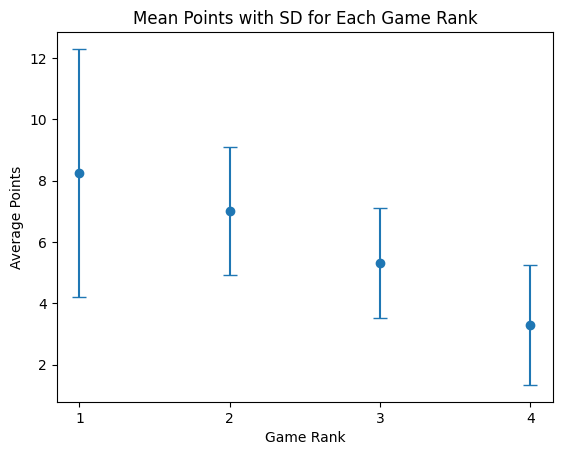

In [276]:
four_player_df = player_df[player_df['Player Count'] == 4]
mean_points = four_player_df.groupby('gamerank')['score'].mean()
std_points = four_player_df.groupby('gamerank')['score'].std()

# Create a graph with error bars
plt.errorbar(mean_points.index, mean_points, yerr=std_points, fmt='o', capsize=5)

# Set x and y axis labels
plt.xlabel('Game Rank')
plt.ylabel('Average Points')

# Set the title for the graph
plt.title('Mean Points with SD for Each Game Rank')

# Display the graph
plt.show()

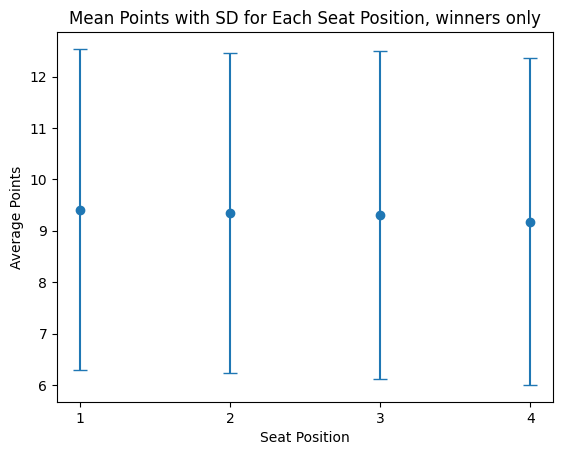

In [279]:
winners = four_player_df[four_player_df['winner']]
winners = winners[winners['Winning Seat'].astype('int64') > 0]
mean_points = winners.groupby('Winning Seat')['score'].mean()
std_points = winners.groupby('Winning Seat')['score'].std()

# Create a graph with error bars
plt.errorbar(mean_points.index, mean_points, yerr=std_points, fmt='o', capsize=5)

# Set x and y axis labels
plt.xlabel('Seat Position')
plt.ylabel('Average Points')

# Set the title for the graph
plt.title('Mean Points with SD for Each Seat Position, winners only')

# Display the graph
plt.show()

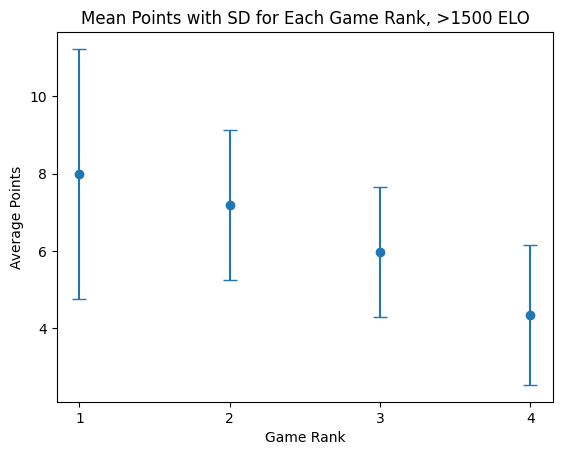

In [278]:
four_player_df = player_df[player_df['Player Count'] == 4]
high_elo_four = four_player_df[four_player_df['Min Elo'] > 1500]
mean_points = high_elo_four.groupby('gamerank')['score'].mean()
std_points = high_elo_four.groupby('gamerank')['score'].std()

# Create a graph with error bars
plt.errorbar(mean_points.index, mean_points, yerr=std_points, fmt='o', capsize=5)

# Set x and y axis labels
plt.xlabel('Game Rank')
plt.ylabel('Average Points')

# Set the title for the graph
plt.title('Mean Points with SD for Each Game Rank, >1500 ELO')

# Display the graph
plt.show()

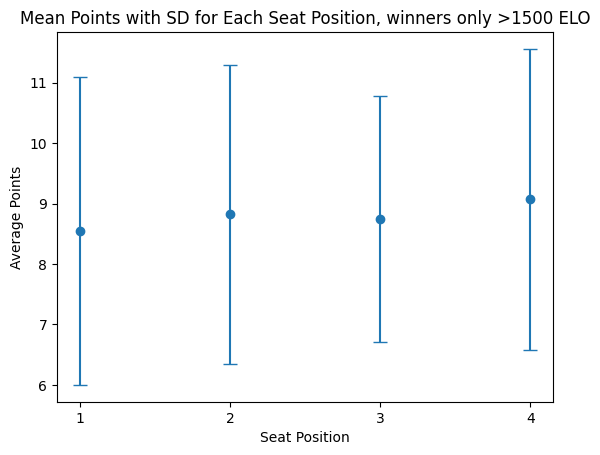

In [281]:
winners = high_elo_four[high_elo_four['winner']]
winners = winners[winners['Winning Seat'].astype('int64') > 0]
mean_points = winners.groupby('Winning Seat')['score'].mean()
std_points = winners.groupby('Winning Seat')['score'].std()

# Create a graph with error bars
plt.errorbar(mean_points.index, mean_points, yerr=std_points, fmt='o', capsize=5)

# Set x and y axis labels
plt.xlabel('Seat Position')
plt.ylabel('Average Points')

# Set the title for the graph
plt.title('Mean Points with SD for Each Seat Position, winners only >1500 ELO')

# Display the graph
plt.show()